# Поиск оптимальной стратегии методом ExpectedSARSA

Реализуем поиск оптимальной стратегии по TD методу ExpectedSARSA. Код для "табличного" агента у нас уже написан. Его можно использовать без изменений.

In [1]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm

class TableAgent:
    def __init__(self, env, eps = 0.1, alpha = 0.1):
        self.nA = env.action_space.n # число действий
        self.Q = defaultdict(lambda: np.zeros(self.nA))   # словарь для хранения оценок ценностей пар состояние-действие
        self.eps = eps               
        self.alpha = alpha           # параметр шага обучения
            
    def reset(self):
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        
    # выбор eps-жадного действия        
    def get_action(self, state):
        if np.random.rand() < self.eps:
            return np.random.choice(self.nA)

        return self.best_action(state)
    
    # выбор жадного действия        
    def best_action(self, state):
        return np.argmax(self.Q[state])
    
    def update(self, state, act, goal):
        # обновление оценки с постоянным шагом обновления
        self.Q[state][act] += self.alpha*(goal - self.Q[state][act])
        
    def get_Q(self, state, act):
        return self.Q[state][act]
  
    def play(self, env, n_episodes):
        for _ in tqdm(range(n_episodes)):
            state, _ = env.reset()
            while True:
                # выбираем лучшие действия
                action = self.best_action(state)
                state, reward, terminated, truncated, _ = env.step(action)
                if terminated or truncated:
                    break

### Задача

Требуется написать управляющую функцию `ExpectedSARSA_control()` для обучения агента по методу ExpectedSARSA, как метода обучения
с единой стратегией с обобщённой итерацией по $\varepsilon$-жадным стратегиям (см. псевдокод в слайдах).

In [7]:
from tqdm import tqdm
    
def ExpectedSARSA_control(env, agent, n_episodes=10000, gamma = 1.0, 
                      eps_start=0.5, eps_decay = 0.99, eps_min = 0.01):
    agent.eps = eps_start
    
    for _ in tqdm(range(n_episodes)):
        state, _ = env.reset()   
        
        # запускаем эпизод взаимодействия со средой        
        while True:
            action = agent.get_action(state)
            
            # Сформировать цель обновления 
            ########################################
            ???
            
            upd_goal = ???
            ########################################
            agent.update(state, action, upd_goal)
            
            state = next_state
            if terminated or truncated:
                break

        # уменьшение доли шагов исследования
        agent.eps = agent.eps * eps_decay
        agent.eps = np.max([agent.eps, eps_min])

### Пример 1

Рассмотрим снова задачу о клеточном мире с утёсом `CliffWalking-v0` и найдём оптимальную стратегию методом ExpectedSARSA.

In [9]:
import gymnasium as gym
# Создание среды
env = gym.make('CliffWalking-v0')
n_episodes = 500
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

# создание табличного агента
agent = TableAgent(env, alpha = 0.25, eps=0.01)

# обучение агента и получение доходов по эпизодам
returns = ExpectedSARSA_control(env, agent, n_episodes = n_episodes, eps_start=0.5, eps_decay = 0.99)

100%|███████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 848.25it/s]


Выведем график доходов за эпизоды, полученных в взаимодействия агента со средой.

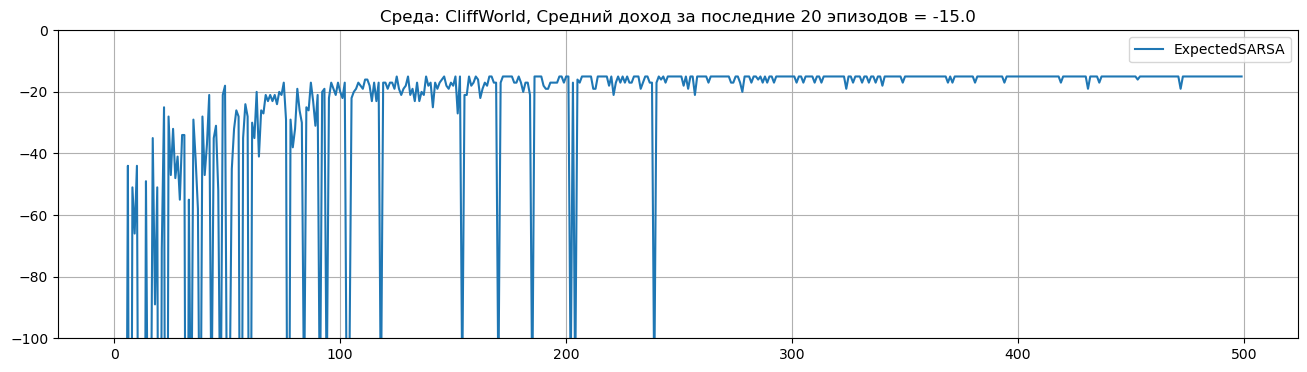

In [11]:
import matplotlib.pyplot as plt
# для того, чтобы избежать ошибок при построении графиков
#import os
#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# в названии графика среднее вознаграждение за 20 последних эпизодов
def plot_rewards(env_name, returns, label):
    fig = plt.figure(figsize=(16, 4))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-100, 0)
    plt.show()
    
# график доходов
returns = np.array(env.return_queue)
plot_rewards("CliffWorld", returns, 'ExpectedSARSA')

График доходов по эпизодам показывает, что уже к 300 эпизоду агент достиг фиксированной стратегии. Можно отметить, что разброс значений чуть ниже, чем у SARSA и Q-обучения. 

Общий доход не оптимален, хотя лучше чем у SARSA. Рассмотрим стратегию, которой обучился агент.

In [15]:
import time
from IPython.display import clear_output

env = gym.make("CliffWalking-v0", render_mode='ansi')
env = gym.wrappers.RecordEpisodeStatistics(env)

state, _ = env.reset()
print(env.render())

while True:
    state, reward, terminated, truncated, _ = env.step(agent.best_action(state)) 
    
    time.sleep(.2)
    clear_output(wait=True)
    print(env.render())

    if terminated or truncated:
        break

print(env.return_queue[-1])
env.close()

o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  o  o  o  o  o  o  o  o  o  o  o
o  C  C  C  C  C  C  C  C  C  C  x


-15.0


Стратегия, которой обучился агент, является в некотором смысле средней между стратегиями, полученными по методам SARSA и Q-обучением. В данном случае мы использовали  Expected SARSA как метод с единой стратегией, то есть одна и та же eps-жадная стратегия используется как для исследования, так и для обновления. Но благодаря выбору математического ожидания вместо одного значения, результат обучения лучше чем у SARSA, то есть агент обнаружил, что по средней линии идти достаточно безопасно.

### Пример 2

Применим метод ExpectedSARSA для решения задачи о такси `Taxi-v3`.

In [17]:
import gymnasium as gym
# Создание среды
env = gym.make('Taxi-v3')
n_episodes = 5000
env = gym.wrappers.RecordEpisodeStatistics(env, n_episodes)

# создание табличного агнета
agent = TableAgent(env, alpha = 0.2)

# обучение агента и получение доходов по эпизодам
returns = ExpectedSARSA_control(env, agent, n_episodes = n_episodes, gamma=0.99, eps_start=1.0, eps_decay = 0.99, eps_min = 0.01)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:06<00:00, 831.27it/s]


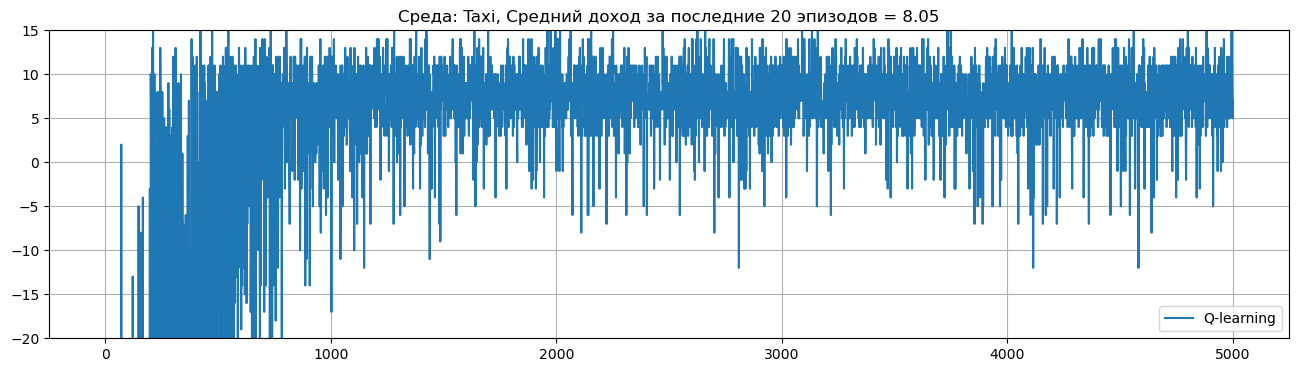

In [19]:
# в названии графика среднее вознаграждение за 20 последних эпизодов
def plot_rewards(env_name, returns, label):
    fig = plt.figure(figsize=(16, 4))
    plt.title("Среда: "+env_name+", Средний доход за последние 20 эпизодов = "+str(np.mean(returns[-20:])))
    plt.plot(returns, label=label)
    plt.grid()
    plt.legend()
    plt.ylim(-20, 15)
    plt.show()

returns = np.array(env.return_queue)
plot_rewards("Taxi", returns, 'Q-learning')

График вознаграждений выводится для фактически полученных вознаграждений из траекторий, генерируемых по eps-жадной стратегии. Если выбирать действия жадно, относительно обученной Q-функции, то агент уже обучился оптимальной стратегии действий. В этом можно убедиться в симуляции.

In [21]:
n_episodes = 10000
env = gym.make("Taxi-v3")
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=n_episodes)

agent.play(env, n_episodes)

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:02<00:00, 4062.69it/s]


Средний доход за эпизод равен: 7.9652
Минимальный доход за эпизод равен: 3.0
Максимальный доход за эпизод равен: 15.0


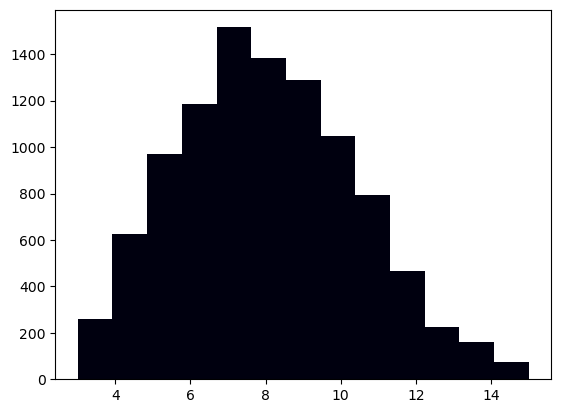

In [22]:
print('Средний доход за эпизод равен:', np.mean(env.return_queue))
print('Минимальный доход за эпизод равен:', np.min(env.return_queue))
print('Максимальный доход за эпизод равен:', np.max(env.return_queue))

import matplotlib.pyplot as plt
plt.hist(env.return_queue, bins=13, color='#00000f')
plt.show()